
# WeightWatcher - VGG

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


VGG is one of the first, large scale modern architectures based on the classic convolutional model of LeCun ,, resembling a larger scale version of LeNet5.  While there are earlier models (AlexNet, etc), VGG is usefukl because:

-  There are several variants, with 11, 13, 16, and 19 layers, and with and wthout Batch Normalization
-  It is widely available in pyTorch and other frameworks
-  There are versions trained on all of ImageNet, ImageNet-1K (a smaller data set), etc.
-  Although large,  is still used in Transfer Learning.

The general VGG series architecture consists of 

-  Several sets of Conv2D+ReLU layers (followed by Max Pooling), with feature maps increasing in size
-  3 final Fully Connected (Dense/Linear) layers

Below we show the VGG16 architecture, consisting of 16 layers.

The VGG series are considered very large models, with an enormous number of parameters comparexd to later models like ResNet and DenseNet series.  Most notably, compared to later models,

-  VGG models contain large, FC layers at the end
-  VGG does not contain residual connections


In [1]:
from IPython.display import Image
Image(filename='VGG16.1.png',width=800, height=400)


In [2]:
Image(filename='VGG16.2.png',width=800, height=400)

It is noted that the VGGNet model (16?) has ov er 2X the number of parameters as one of the largest ResNet models, with far less top5 accuracy.  

In [3]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

## Summary of results


We first compute the Average Alpha $\langle\alpha\rangle$ for all models, and compare to the Test Accuracy accross the models.  In contrast to expectations, and other models like ResNet, on average, $\langle\alpha\rangle$ is increasing with Test Accuracy instead of decreasing.  In fact, $\langle\alpha\rangle$ is strongly *negatively correlated* with reported Test Accuracy.  

#### Why is this ?

If we look at $\alpha$ vs Layer Id, we see that  $\alpha$ is increasing with Layer Id. That is, as information flows thorugh the network, the layers are less and less correlated.  THis suggests (to me) that the VGG networks are fairly bad at funneling information through the network.

Instead, we need to use the Weighted Alpha metric $\hat{\alpha}$ , which is positively correlated with the Test Accuracy.  

## Calculation of Results

In [4]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [6]:
import weightwatcher as ww
import torchvision.models as models

ww.__version__

'0.4.0'

###  Helper Notebook to make Plots


In [7]:
import import_ipynb
import ModelPlots as MP

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

Pick colors from https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [8]:
series_name = 'VGG'
all_names = [ 'vgg11', 'vgg13',  'vgg16',  'vgg19', ]
colors =    ['indigo', 'purple','darkgreen', 'red']


all_models = []
all_models.append(models.vgg11(pretrained=True))

#all_models.append(models.vgg13(pretrained=True))

#all_models.append(models.vgg16(pretrained=True))

#all_models.append(models.vgg19(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>VGG-11</p></td>
<td><p>30.98</p></td>
<td><p>11.37</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13</p></td>
<td><p>30.07</p></td>
<td><p>10.75</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16</p></td>
<td><p>28.41</p></td>
<td><p>9.62</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19</p></td>
<td><p>27.62</p></td>
<td><p>9.12</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-11 with batch normalization</p></td>
<td><p>29.62</p></td>
<td><p>10.19</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13 with batch normalization</p></td>
<td><p>28.45</p></td>
<td><p>9.63</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16 with batch normalization</p></td>
<td><p>26.63</p></td>
<td><p>8.50</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19 with batch normalization</p></td>
<td><p>25.76</p></td>
<td><p>8.15</p></td>
</tr>
</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "vgg11": 30.98,
    "vgg11_bn": 29.62,
    "vgg13": 30.07,
    "vgg13_bn": 28.45,
    "vgg16": 28.41,
    "vgg16_bn": 26.63,
    "vgg19": 27.62,
    "vgg19_bn": 25.76,
}

In [10]:
top5_errors= {
    
    "vgg11": 11.37,
    "vgg11_bn": 10.19,
    "vgg13": 10.75,
    "vgg13_bn": 9.63,
    "vgg16": 9.62,
    "vgg16_bn": 8.50,
    "vgg19": 9.12,
    "vgg19_bn": 8.15,
}

In [11]:
all_models[0]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [12]:
watcher = ww.WeightWatcher(model=all_models[0])

INFO:WeightWatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0


### Run WeightWatcher, collect summary and details (as dataframes) for all models

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 64x3 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=64 M=3 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
INFO:WeightWatcher:fitting power law on 27 eigenvalues
DEBUG:matplotlib.ticker:vmin 21.426543119841792 vmax 121.08551345586987
DEBUG:matplotlib.ticker:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 4.971363636363637
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: scor

 evals [  3.76467373   3.96619239   4.01655051   5.32485448   5.35420219
   5.47538744   6.31692372   6.75737595   7.22194715  12.20980681
  23.18143383  23.33464166  23.55389858  25.77796472  33.99748879
  34.14079483  34.27872586  37.28691562  44.8738089   52.8471398
  53.06330447  59.60883884  80.27209334  89.61912741 101.05610223
 101.1520611  111.91904671]


DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-SemiboldItalic.otf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-SemiboldItalic.otf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-LightItalic.otf) italic normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactR

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-SemiboldItalic.otf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-LightItalic.otf) italic normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Thin.otf) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STI

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 10.434999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 250 normal>) = 11.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_man

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal 800 condensed>) = 11.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Thin.otf) normal normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.335
DEBU

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 600 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal 800 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal 900 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal 900 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 250 normal>) = 10.4775
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal 800 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Thin.otf) normal normal 200 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal 800 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) 

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEB

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal 900 condensed>) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 10.43
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: sco

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Black.otf) normal normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal 900 condensed>) = 11.725
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.ot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 11.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 10.335
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.335
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Black.otf) normal normal 900 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-M

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal 900 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.otf) normal normal 100 normal>) = 10.62
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.71025
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinI

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.otf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetChero

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXS

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.otf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotli

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal 900 condensed>) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:f

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal 900 condensed>) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.otf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.o

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXS

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Ultralight.otf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotli

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 norma

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<F

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.f

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fo

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 11.3449

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 11.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinha

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 11.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findf

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) ita

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) norma

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) italic normal 100 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed'

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotl

DEBUG:matplotlib.ticker:vmin 18.085413649756703 vmax 43.13675543746977
DEBUG:matplotlib.ticker:ticklocs array([   1.,   10.,  100., 1000.])
DEBUG:matplotlib.ticker:vmin 18.085413649756703 vmax 43.13675543746977
DEBUG:matplotlib.ticker:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs arr

DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+

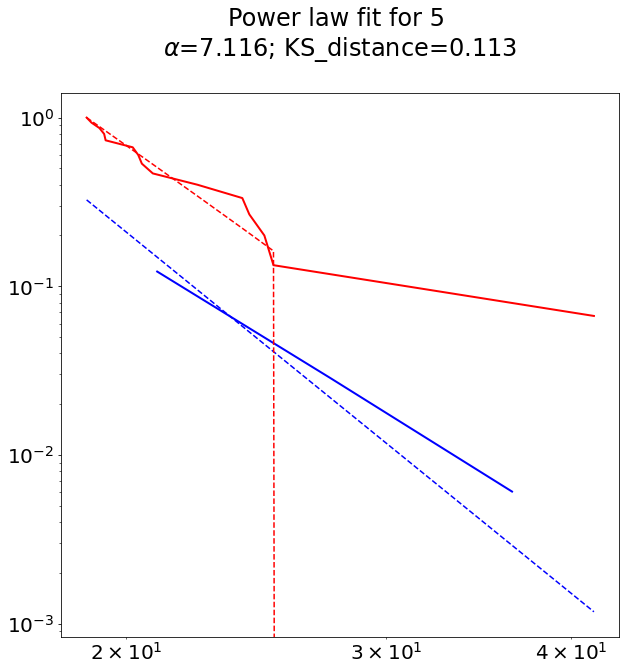

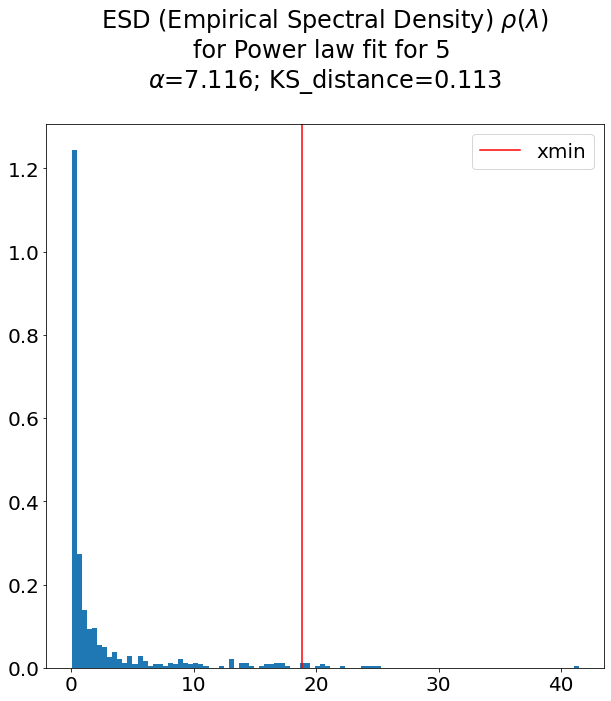

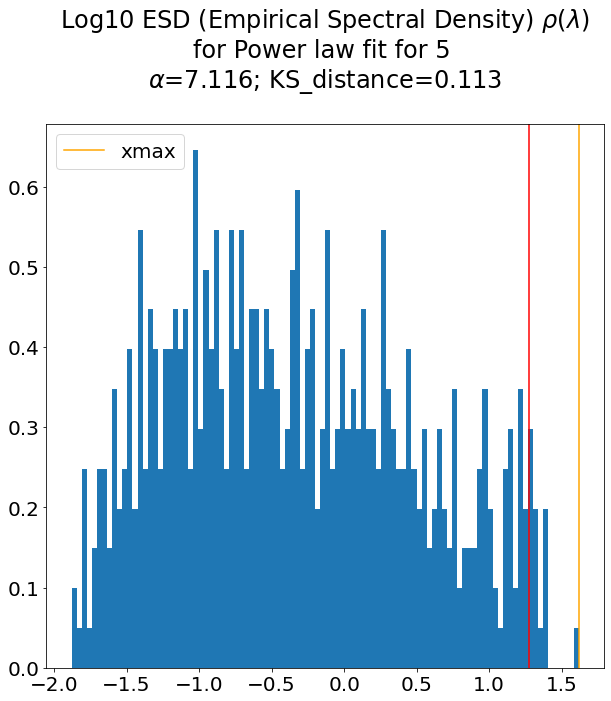

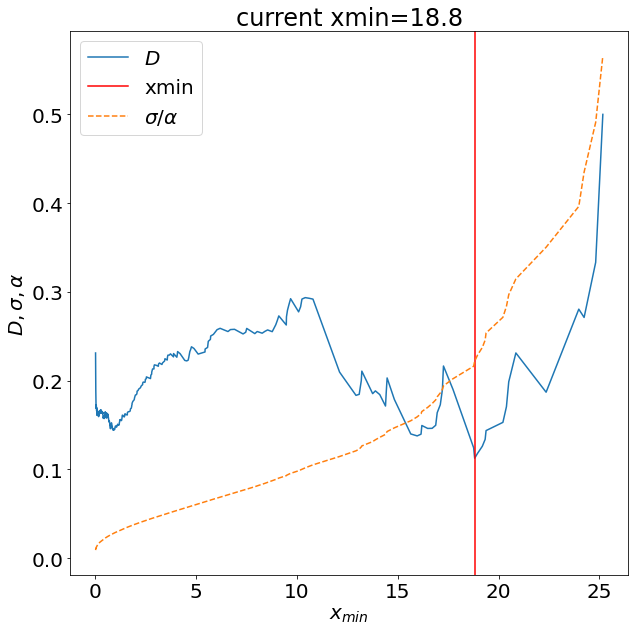

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 256x128 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=256 M=128 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
INFO:WeightWatcher:fitting power law on 1152 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 1152 


 evals [2.75943149e-02 2.87723048e-02 3.00884229e-02 ... 2.24180278e+01
 3.17427359e+01 3.45053382e+01]


DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.0008293788159118006 vmax 1.4019291000543694
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 

DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.8810158579739396 vmax 34.70284090566255
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0008293788159118006 vmax 1.4019291000543694
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008293788159118006 vmax 

DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008293788159118006 vmax 1.4019291000543694
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008293788159118006 vmax 1.4019291000543694
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008293

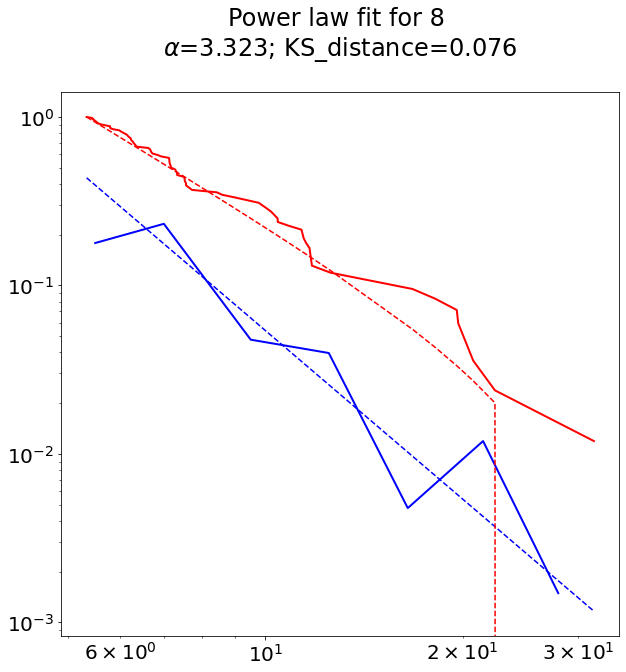

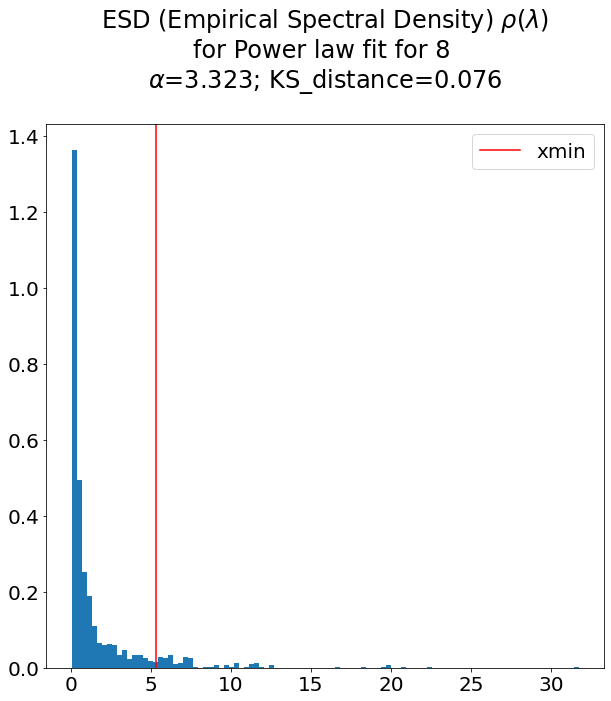

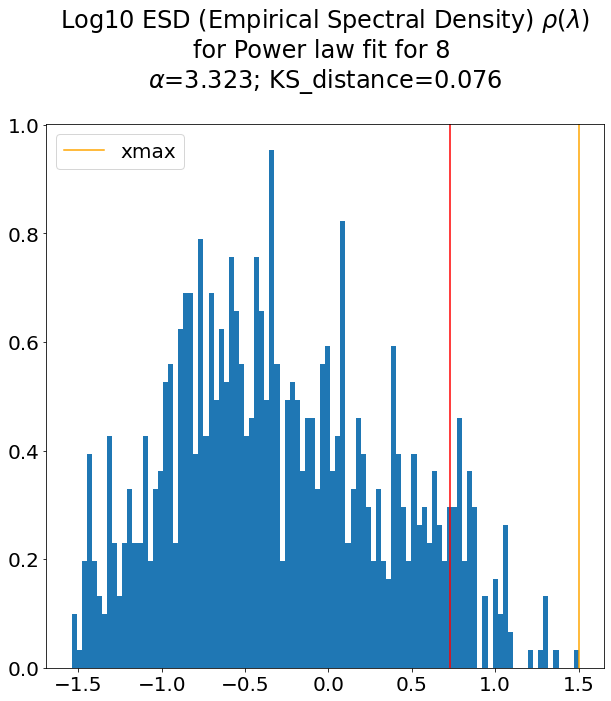

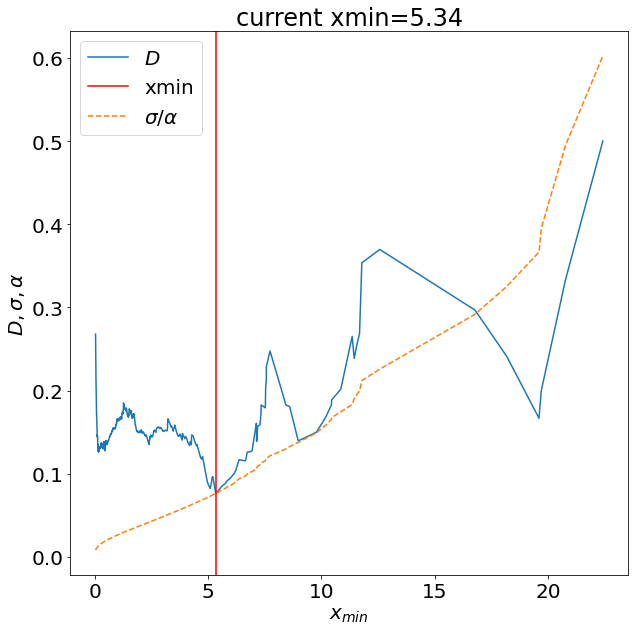

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 256x256 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=256 M=256 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
INFO:WeightWatcher:fitting power law on 2304 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 2304 


 evals [2.64091641e-08 2.66210200e-08 2.64366714e-06 ... 1.57415068e+01
 1.68336165e+01 2.58879994e+01]


DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.0007826398247685645 vmax 1.4058067418821842
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+

DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.9449206328852973 vmax 28.711247089747058
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0007826398247685645 vmax 1.4058067418821842
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0007826398247685645 vm

DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0007826398247685645 vmax 1.4058067418821842
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 0.0007826398247685645 vmax 1.4058067418821842
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0007826

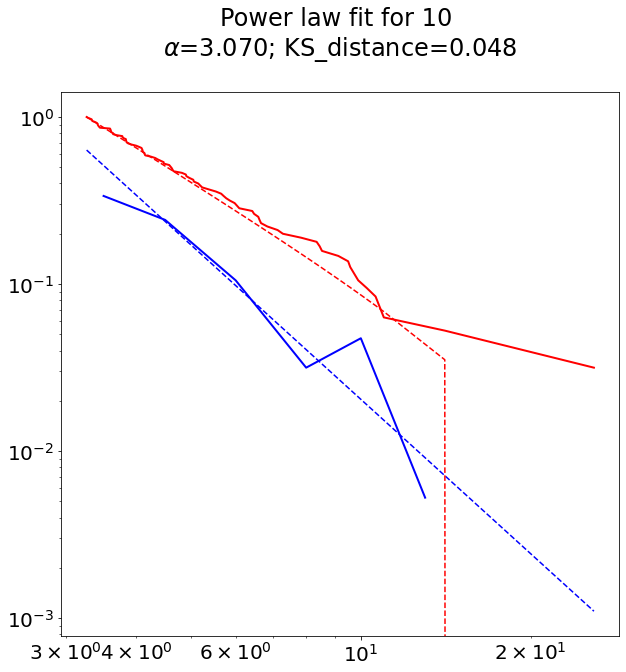

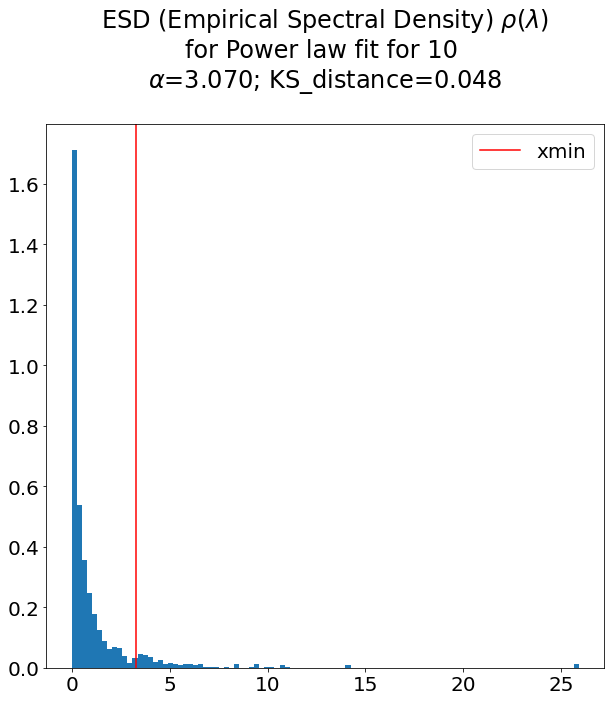

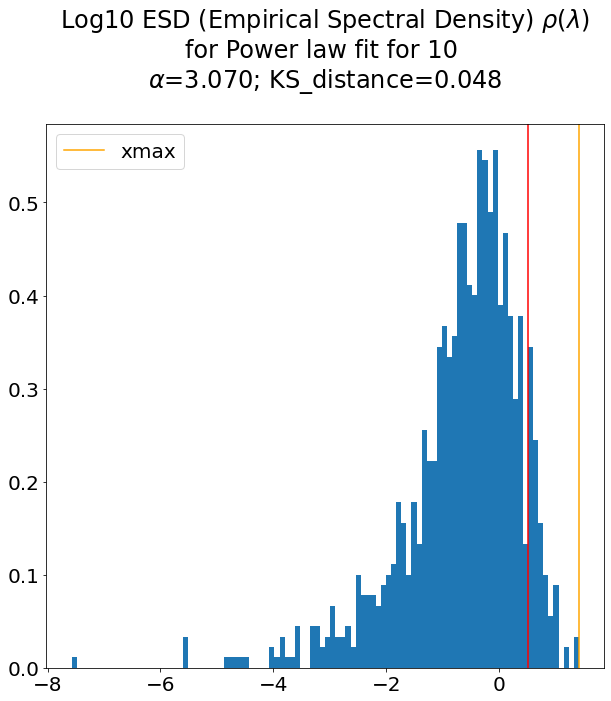

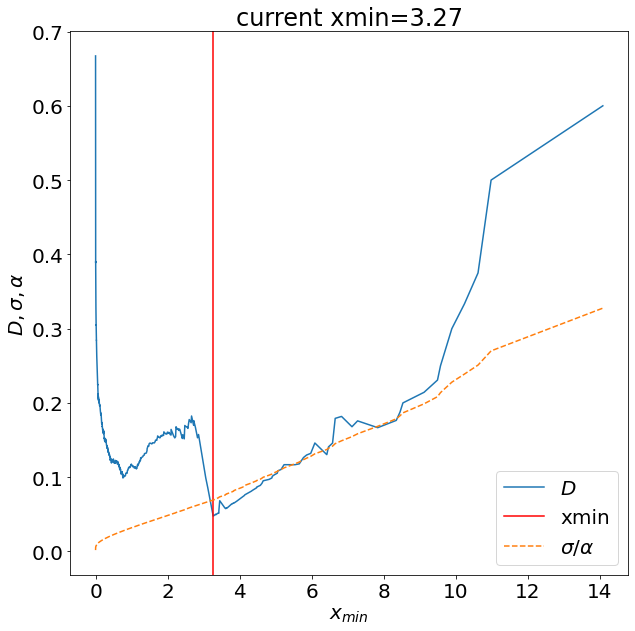

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x256 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=256 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
INFO:WeightWatcher:fitting power law on 2304 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 2304 


 evals [ 0.03438845  0.04036158  0.04186225 ... 18.4807863  18.76224099
 32.11228183]


DEBUG:matplotlib.ticker:vmin 2.764448509955258 vmax 20.553620746034298
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 2.764448509955258 vmax 20.553620746034298
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.764448509955258 vmax 20.553620746034298
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.764448509955258 vmax 20.553620746034298
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8

DEBUG:matplotlib.ticker:vmin 2.764448509955258 vmax 20.553620746034298
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-0

DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.002648374377806952 vmax 1.3265244762381505
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])


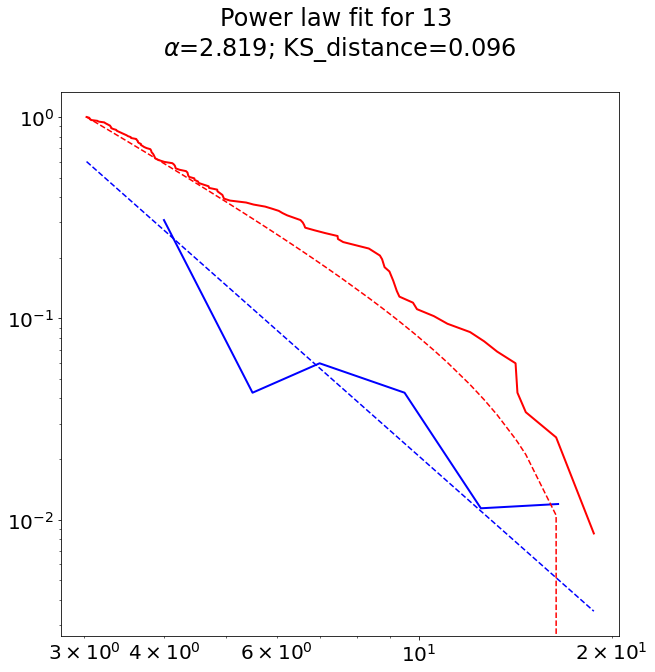

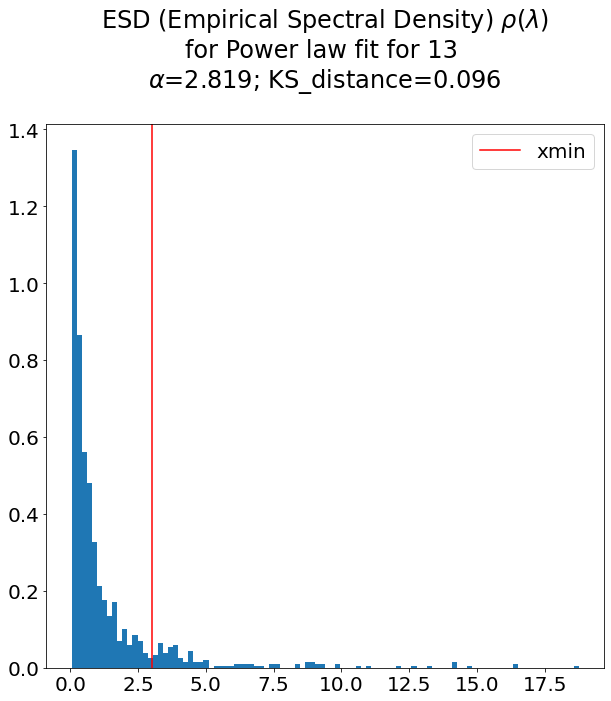

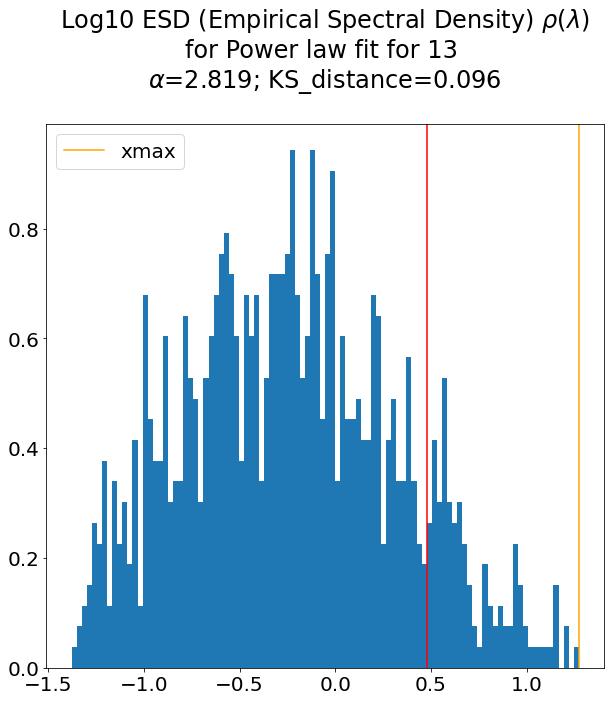

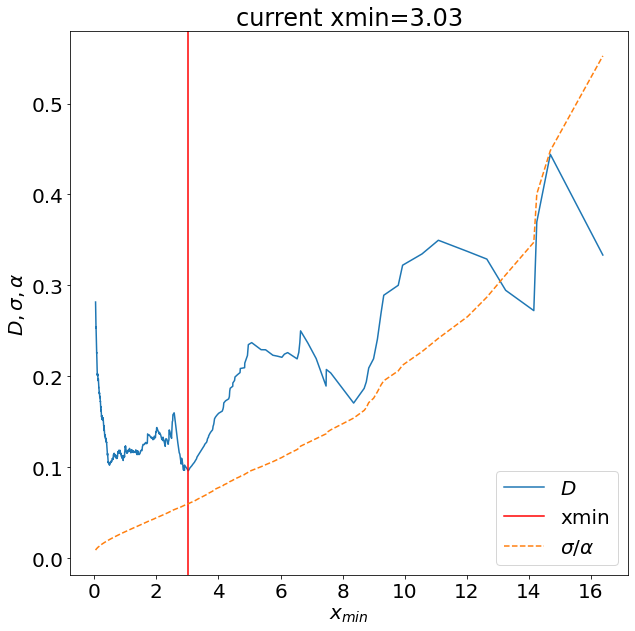

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 


 evals [3.73230408e-08 5.29695991e-08 2.19476233e-07 ... 2.70429457e+01
 2.82320144e+01 4.20613764e+01]


DEBUG:matplotlib.ticker:vmin 1.8337029373176454 vmax 22.19929198878638
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 1.8337029373176454 vmax 22.19929198878638
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 1.8337029373176454 vmax 22.19929198878638
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 1.8337029373176454 vmax 22.19929198878638
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 

DEBUG:matplotlib.ticker:vmin 1.8337029373176454 vmax 22.19929198878638
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.

DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0011546805625847645 vmax 1.3800117011287496
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])


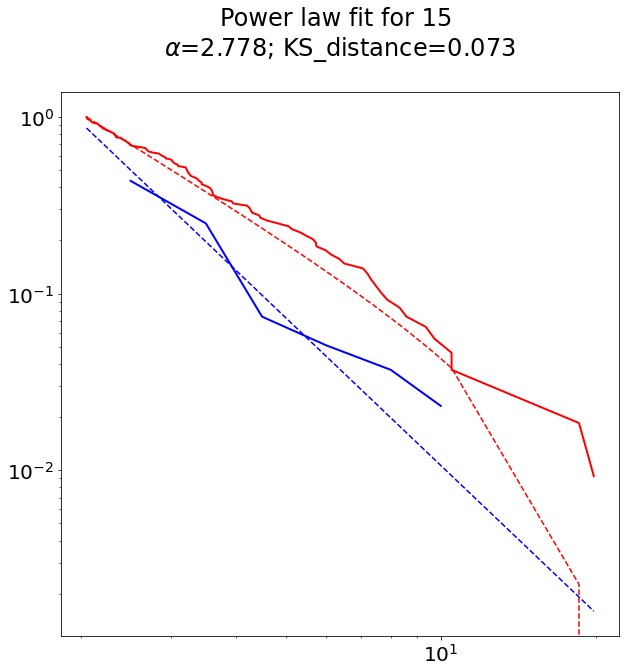

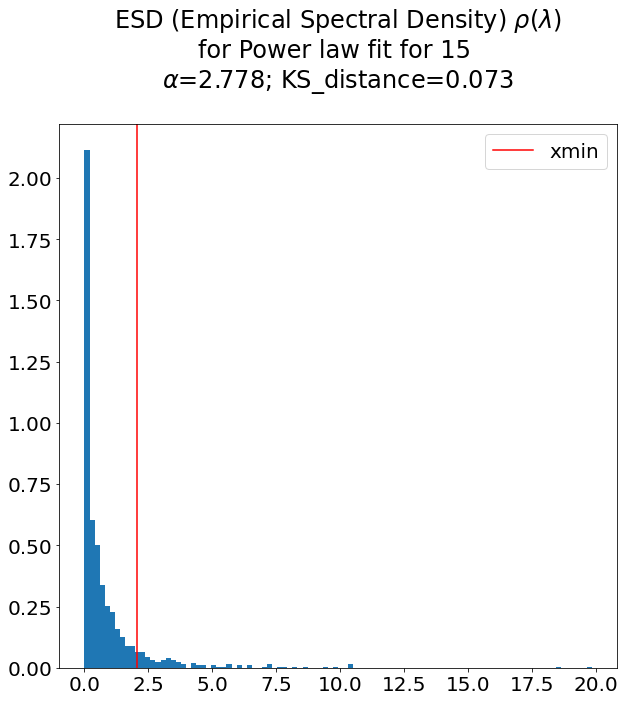

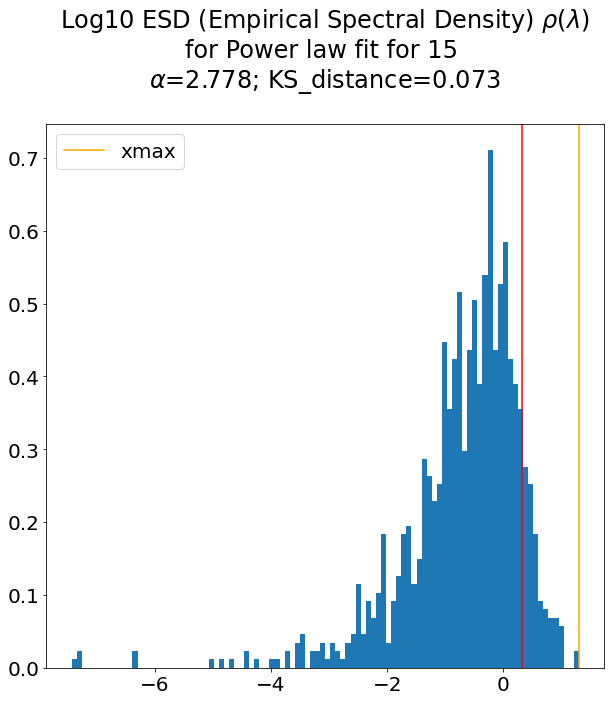

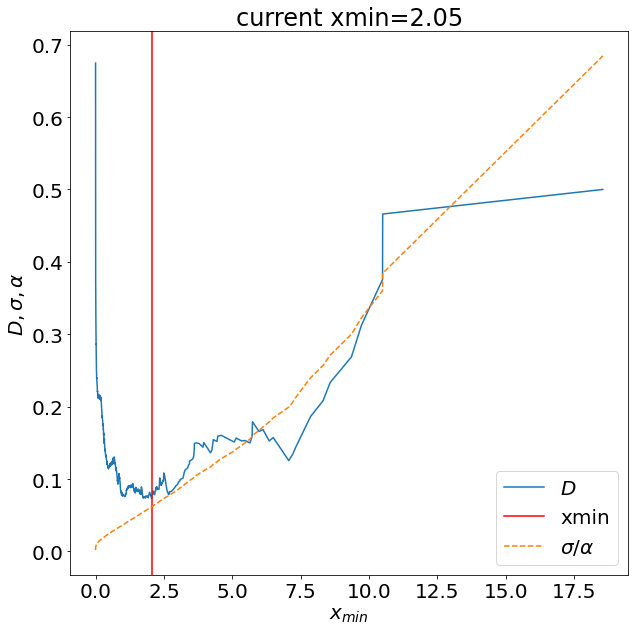

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 


 evals [4.98940398e-11 2.52209233e-07 4.84559426e-07 ... 1.85180042e+01
 1.93103392e+01 3.11774626e+01]


DEBUG:matplotlib.ticker:vmin 1.3336019142380249 vmax 17.7197375414669
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 1.3336019142380249 vmax 17.7197375414669
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 1.3336019142380249 vmax 17.7197375414669
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 1.3336019142380249 vmax 17.7197375414669
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+

DEBUG:matplotlib.ticker:vmin 1.3336019142380249 vmax 17.7197375414669
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e

DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0022838283590930378 vmax 1.3359122443420142
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])


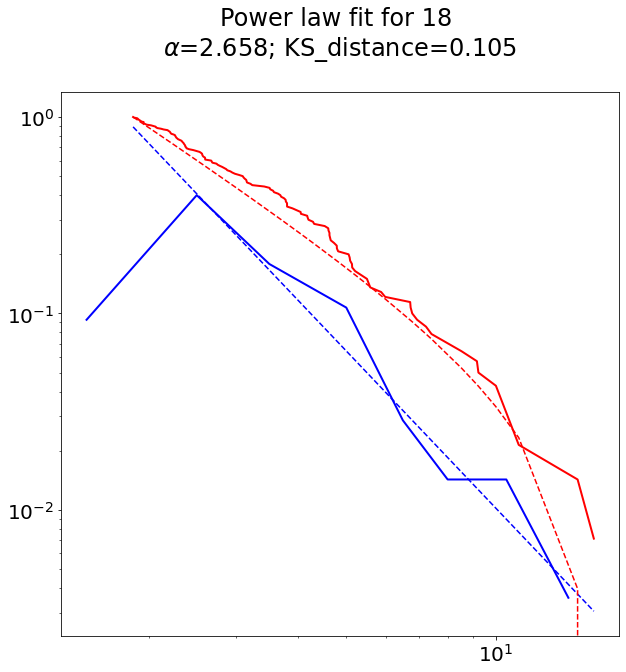

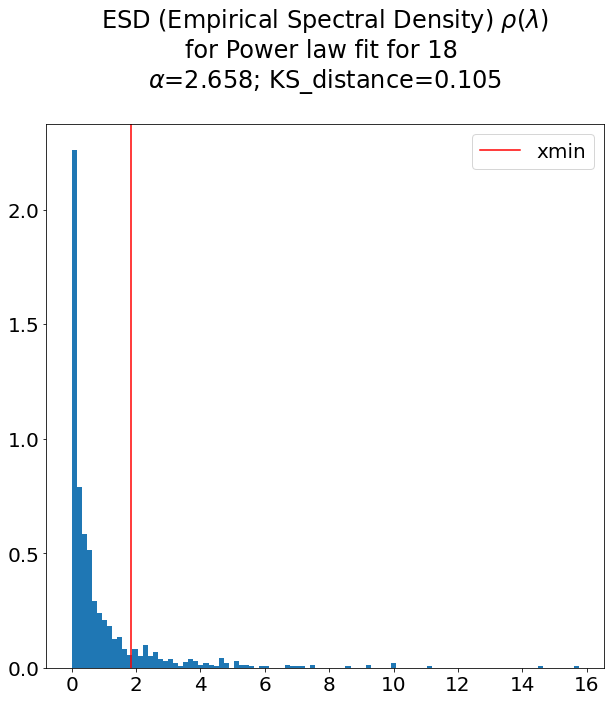

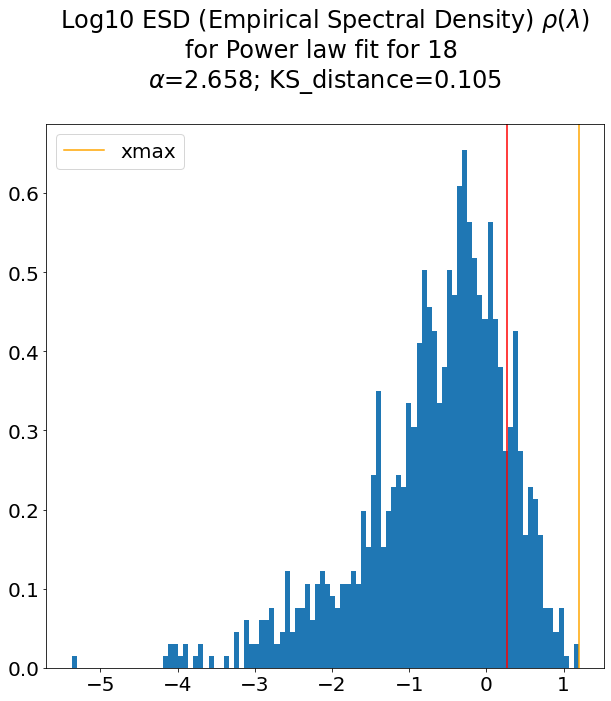

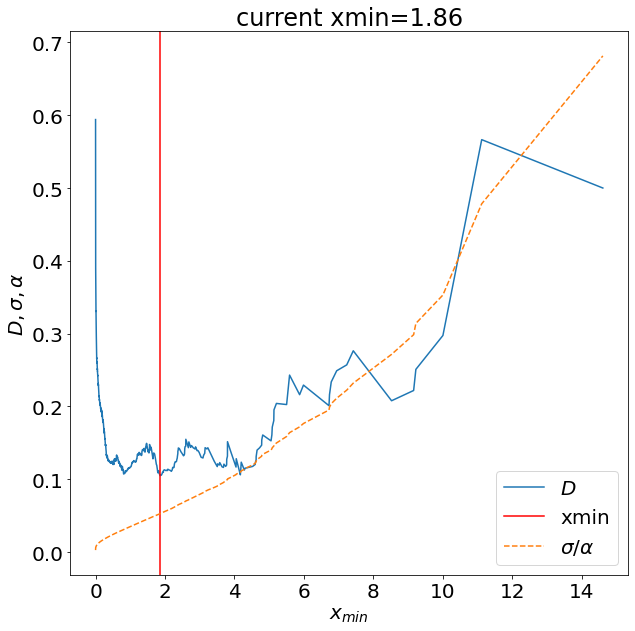

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 


 evals [1.00888586e-08 2.62028968e-08 3.16515951e-08 ... 4.24932754e+01
 4.46987145e+01 5.34941869e+01]


DEBUG:matplotlib.ticker:vmin 1.3902383532452167 vmax 7.398320217777202
DEBUG:matplotlib.ticker:ticklocs array([  0.1,   1. ,  10. , 100. ])
DEBUG:matplotlib.ticker:vmin 0.005027628716704675 vmax 1.8618896046449351
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 1.3902383532452167 vmax 7.398320217777202
DEBUG:matplotlib.ticker:ticklocs array([  0.1,   1. ,  10. , 100. ])
DEBUG:matplotlib.ticker:vmin 1.3902383532452167 vmax 7.398320217777202
DEBUG:matplotlib.ticker:ticklocs array([  0.1,   1. ,  10. , 100. ])
DEBUG:matplotlib.ticker:vmin 1.3902383532452167 vmax 7.398320217777202
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.tic

DEBUG:matplotlib.ticker:vmin 0.005027628716704675 vmax 1.8618896046449351
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.005027628716704675 vmax 1.8618896046449351
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 0.005027628716704675 vmax 1.8618896046449351
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.005027628716704675 vma

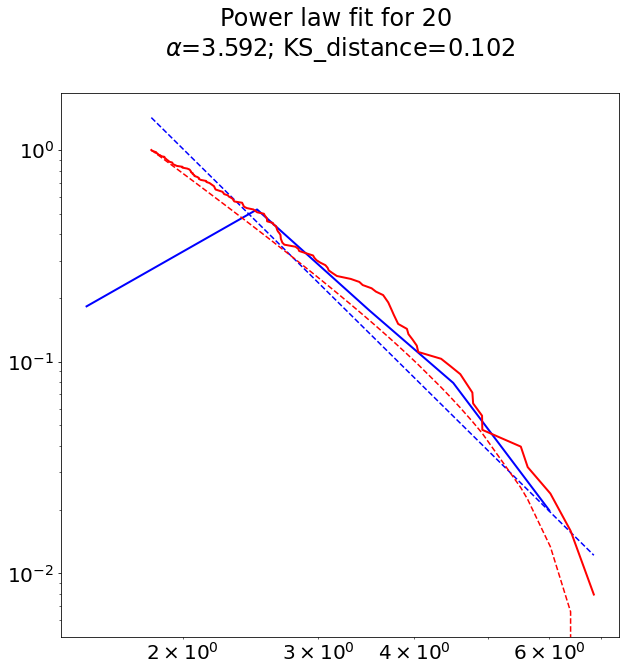

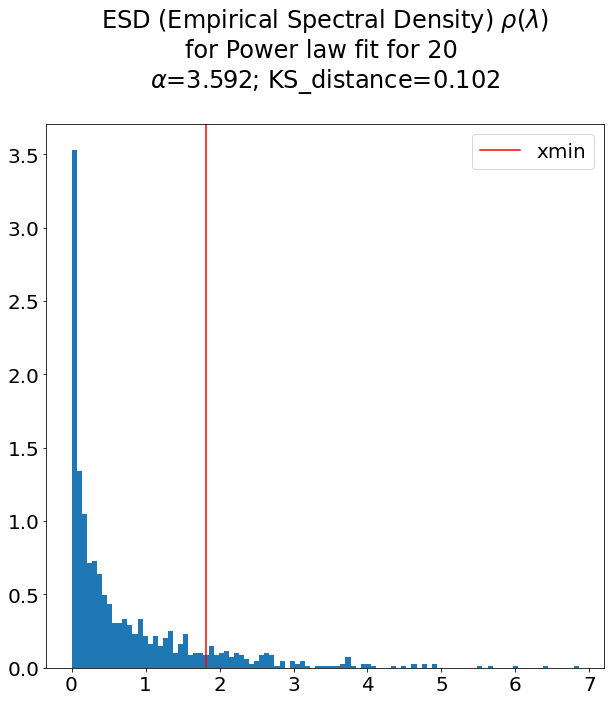

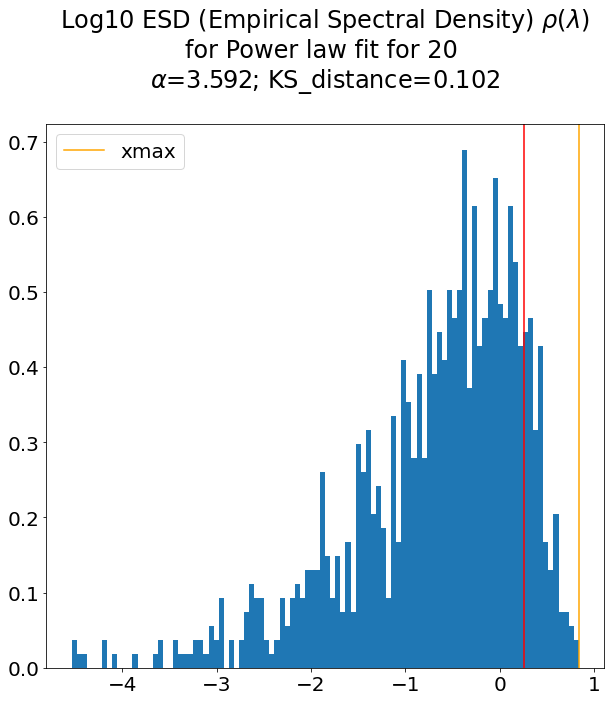

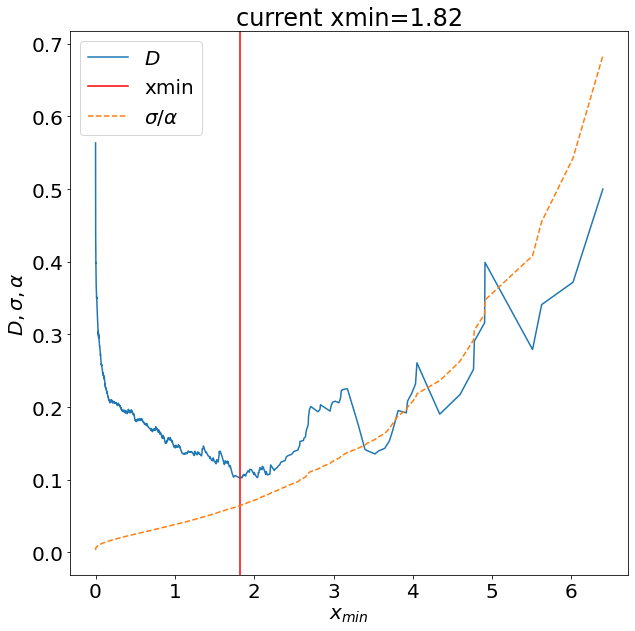

DEBUG:WeightWatcher:Layer 25 : size 25088 > 10000
DEBUG:WeightWatcher:Layer 25 : size 25088 > 10000
DEBUG:WeightWatcher:Running full SVD:  W.shape=(4096,)  n_comp = 4096


 evals None


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [13]:
details = watcher.analyze(alphas=True,  normalize=False, glorot_fix=False, plot=True)

In [ ]:
details